# Time-lapse tracer experiment in sand column
TODO simplify the example (only keep dataset used) and add more context
In this experiment, time-lapse ERT is used to monitor the infiltration of a tracer in a sand column.

- injection at 40 mm/h
- 2000 uS/cm for 120 min
- seq2 with 250 ms on-time

Plan of the experimental setup:

<img src="img/column-schema.jpg" width="400" height="1000">

In [1]:
 # trick to import a resipy from a local copy (you won't need that if you `pip install resipy`)
import sys 
sys.path.append('../src')

from resipy import R2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyvista as pv
import os
import shutil

datadir = '../src/examples/dc-3d-timelapse-column/'

API path =  /media/jkl/data/phd/tmp/resipy/src/resipy
ResIPy version =  2.2.3
cR2.exe found and up to date.
R3t.exe found and up to date.
cR3t.exe found and up to date.


In [2]:
# each sequence is actually composed of 24 repeated injection
# the function below separate each set of injection into different
# dataframe
def writedf(fnames, wd, stride=1):
    if os.path.exists(wd + 'data/'):
        shutil.rmtree(wd + 'data/')
    os.mkdir(wd + 'data/')
    dfs = []
    c = 0
    for i, fname in enumerate(fnames):
        df = pd.read_csv(datadir + 'ert/' + fname + '.csv')
        for j in range(0, df.shape[0]//100, stride):
            sdf = df[j*100:(j+1)*100]
            dfs.append(sdf)
            c += 1
            sdf.to_csv(wd + 'data/dataset{:03.0f}.csv'.format(c), index=False)
    return dfs

def showOutflow(fname, ax=None, label=''):
    df = pd.read_csv(fname, header=2, sep=' ')
    df['hh:mm:ss'] = pd.to_datetime(df['hh:mm:ss'])
    df['t'] = [(a - df['hh:mm:ss'].values[0]).seconds for a in df['hh:mm:ss']]
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(df['t'], df['mS'], '.-', label=label)
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('mS')

def showEvol(k, dt=2, ax=None): # dt is time interval in seconds
    vals = np.vstack([s.df['resist'].values[0::20] for s in k.surveys])
    xx = np.arange(0, len(k.surveys))*dt
    if ax == None:
        fig, ax = plt.subplots()
    for i in range(vals.shape[1]):
        ax.semilogy(xx, vals[:,i], '.-', label='ring {:d}'.format(i+1))
    ax.set_xlabel('Time [s]')
    ax.legend()
    ax.set_ylabel(r'Transfer Resistance [$\Omega$]')

In [3]:
fnames = ['202030201',
          '202030202']
# k = R2(datadir, typ='R3t')
k = R2(typ='R3t')
k.dirname = datadir + 'invdir/'
dfs = writedf(fnames, datadir, stride=5)
k.createTimeLapseSurvey(datadir + 'data/')

Working directory is: /media/jkl/data/phd/tmp/resipy/src/examples/dc-3d-timelapse-column
clearing dirname
64/64 imported


In [4]:
# TODO make this simpler
radius = 6.5/2 # cm
angles = np.linspace(0, 2*np.pi, 13)[:-1] # radian
celec = np.c_[radius*np.cos(angles), radius*np.sin(angles)]
elec = np.c_[np.tile(celec.T, 8).T, np.repeat(6.5+np.arange(0, 8*5.55, 5.55)[::-1], 12)]

s2 = np.unique(k.surveys[0].df[['a','b','m','n']].values.flatten())
ielec = k.elec['x'].astype(int).values # electrode indices used in the sequence
x = elec[ielec,:]
k.setElec(x)
# k.importElec(datadir + 'elec.csv') # as not all electrode of a ring are used so label don't match

R3t
           x         y      z  remote  buried label
0   2.814583  1.625000  45.35   False   False     1
1  -1.625000  2.814583  45.35   False   False     2
2  -2.814583 -1.625000  45.35   False   False     3
3   1.625000 -2.814583  45.35   False   False     4
4   2.814583  1.625000  39.80   False   False     5
5  -1.625000  2.814583  39.80   False   False     6
6  -2.814583 -1.625000  39.80   False   False     7
7   1.625000 -2.814583  39.80   False   False     8
8   2.814583  1.625000  34.25   False   False     9
9  -1.625000  2.814583  34.25   False   False    10
10 -2.814583 -1.625000  34.25   False   False    11
11  1.625000 -2.814583  34.25   False   False    12
12  2.814583  1.625000  28.70   False   False    13
13 -1.625000  2.814583  28.70   False   False    14
14 -2.814583 -1.625000  28.70   False   False    15
15  1.625000 -2.814583  28.70   False   False    16
16  2.814583  1.625000  23.15   False   False    17
17 -1.625000  2.814583  23.15   False   False    18
18 -2.81

In [5]:
#k.surveys = k.surveys[::2][:100] # 41.25 s per survey (each survey is 100 quadrupoles) so every 2.75 min
#k.param['reg_mode'] = 1 # background constrain
k.importMesh(datadir + 'mesh3d.dat')
# k.param['node_elec'] = np.c_[np.arange(len(ielec))+1, ielec+1]
k.param['num_xy_poly'] = 0
k.param['xy_poly_table'] = []
k.param['zmin'] = -10
k.param['zmax'] = 50
k.param['a_wgt'] = 0.02
# k.invert(parallel=True)
k.getResults()

Writing .in file and protocol.dat... Matching quadrupoles between surveys for difference inversion...100 in common...done in 0.19609s
done!
------------ INVERTING REFERENCE SURVEY ---------------


 >> R 3 t     E R T    M o d e l    v2.01 <<

 >> Date: 31-08-2020
 >> My beautiful 3D survey                                                          
 >> I n v e r s e   S o l u t i o n   S e l e c t e d <<
 >> T e t r a h e d r a l   E l e m e n t   M e s h <<

 >> Reading mesh file 
 >> Determining storage needed for finite element conductance matrix
 >> Generating index array for finite element conductance matrix
 >> Reading resistivity model from res0.dat                                                                        

 >> L o g - D a t a   I n v e r s i o n <<
 >> N o r m a l   R e g u l a r i s a t i o n <<

 >> Memory estimates:
    For   1000 measurements the memory needed is:          0.452 Gb
    For   2000 measurements the memory needed is:          0.892 Gb
    For   50

In [7]:
k.meshResults[0].df.columns

Index(['param', 'elm_id', 'region', 'cellType', 'X', 'Y', 'Z', 'Resistivity',
       'Resistivity(log10)', 'Sensitivity_map(log10)', 'Parameter_zones',
       'Conductivity(mS/m)'],
      dtype='object')

In [9]:
#k.computeDiff() # run once
res0 = np.array(k.meshResults[0].df['Resistivity'])
for i, m in enumerate(k.meshResults):
    res = np.array(m.df['Resistivity'])
    m.df['difference(percent)'] = list((res-res0)/res0*100)
    m.vtk(datadir + 'out{:03d}.vtk'.format(i))

write_vtk is depreciated, use vtk instead


(0.0, 16186.8)

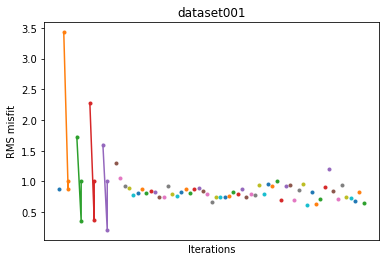

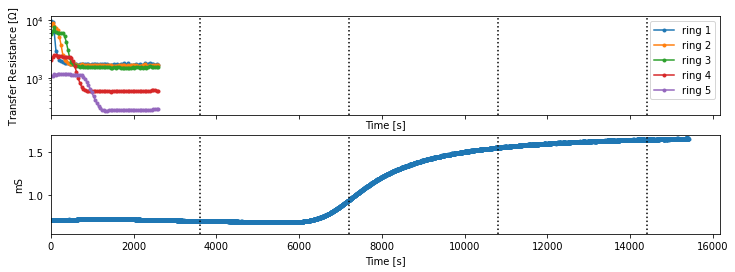

In [10]:
k.showRMS()
steps = np.array([60, 120, 180, 240])*60
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(12,4))
showEvol(k, dt=41.25, ax=axs[0])
[axs[0].axvline(a, color='k', linestyle=':') for a in steps]
showOutflow(datadir + 'outflow/20030201.txt', ax=axs[1])
[axs[1].axvline(a, color='k', linestyle=':') for a in steps]
axs[1].set_ylim([0.55, 1.7])
axs[1].set_xlim([0, None])
#fig.savefig(outputdir + 'evolution.png')

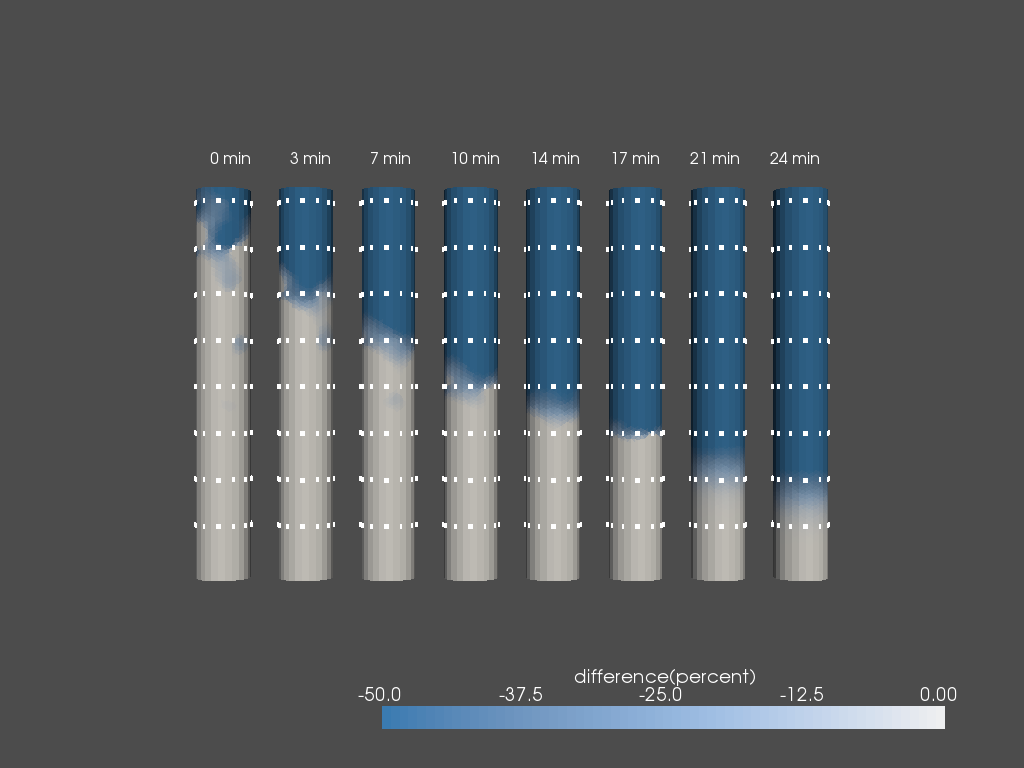

In [33]:
p = pv.Plotter(notebook=True)
for i in np.arange(0, 40, 5):
    offset = i*2
    mesh = pv.read(datadir + 'out{:03d}.vtk'.format(i+1))
    mesh.translate([offset, 0, 0])
    p.add_mesh(mesh, scalars='difference(percent)', cmap='blues_r', clim=(-50, 0))
    melec = pv.PolyData(elec)
    melec.translate([offset, 0, 0])
    p.add_mesh(melec)
    p.add_text('{:.0f} min'.format(i*41.25/60), position=(210 + offset*8, 600), font_size=8)
p.view_xz()
p.show()

NOTE: opening all the vtk in paraview, enables to create an animated gif that shows the tracer progression in the column.

<img src="./img/column.gif" width="500">